In [1]:
# %load_ext autoreload

# %autoreload 2
import os
# os.chdir("..")

import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline

# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:  
- сохраненные значения метрик на `val` в формате `pred_val_template.csv`;
- html страницу с предсказанием модели для всех картинок из `real_test` и папку с используемыми картинками в этой html странице.  
  
Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (можно прямо в ноутбуке) с описанием Вашего исследования, гипотез, анализ данных и т.п.

Примеры приведены ниже.

---

# Данные, метрики и доступные функции

Посмотрим на данные:

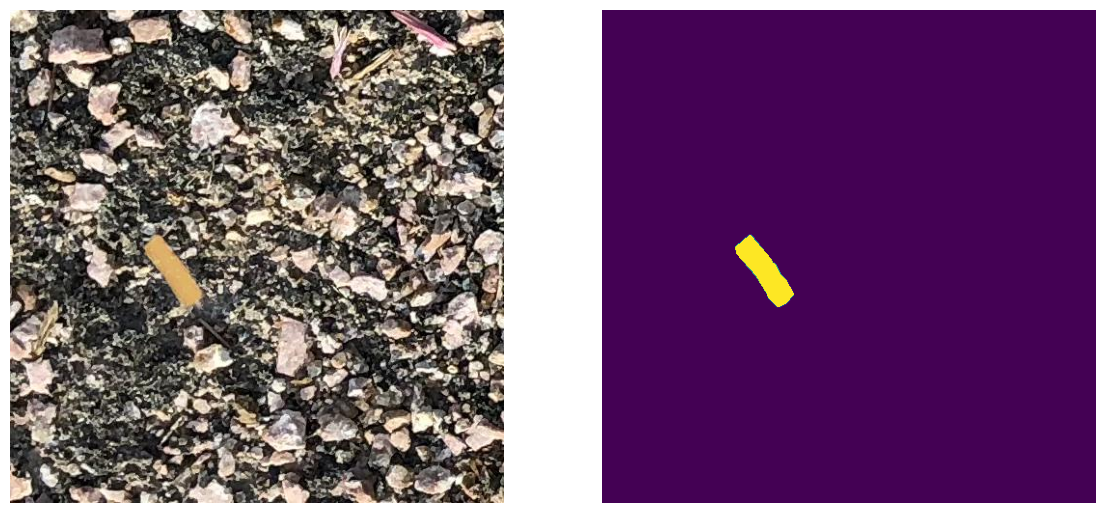

In [5]:
path = "data/train"
images = os.listdir(f"{path}/images")
annotations = json.load(open(f"{path}/coco_annotations.json", "r"))
img_id = int(np.random.choice(images).split(".")[0])

img = np.array(Image.open(f"{path}/images/{img_id:08}.jpg"))
mask = get_mask(img_id, annotations)
show_img_with_mask(img, mask)

Пример подсчета метрики:

In [6]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask)

0.01410664200260175

Можно для последовательности масок вычислить среднее значение метрики:

In [7]:
random_masks_1 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
random_masks_2 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
get_dice(random_masks_1, random_masks_2)

0.4999144020886816

Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [9]:
rle_mask = encode_rle(mask)
rle_mask

'119961 3 120472 5 120983 7 121493 10 122004 11 122515 13 123026 15 123537 17 124048 19 124558 22 125069 23 125580 25 126091 27 126603 28 127115 29 127627 30 128140 29 128652 30 129164 31 129676 32 130189 32 130702 32 131215 31 131727 32 132240 32 132753 32 133266 31 133779 31 134292 30 134805 31 135318 31 135830 32 136343 31 136856 31 137369 30 137882 30 138395 29 138908 29 139421 28 139933 29 140446 28 140959 28 141472 28 141985 28 142497 29 143010 29 143523 29 144035 30 144548 29 145060 30 145573 29 146086 29 146598 29 147111 29 147624 29 148136 29 148649 29 149161 29 149674 29 150187 28 150699 29 151212 28 151724 28 152236 27 152749 25 153261 24 153774 22 154287 21 154800 19 155313 17 155826 15 156339 13 156852 10 157365 7 157878 4'

Теперь восстановим маску:

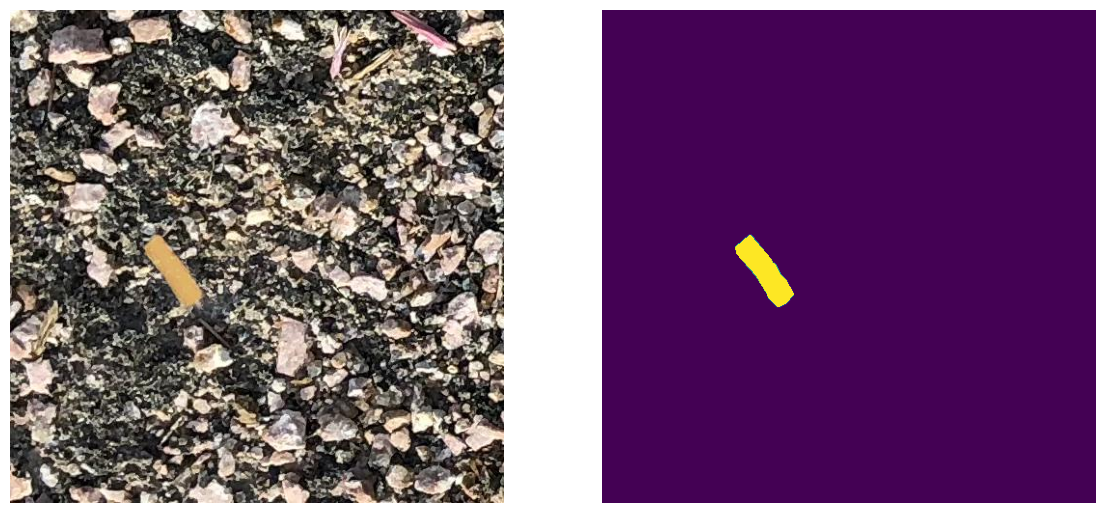

In [44]:
decoded_mask = decode_rle(rle_mask)
show_img_with_mask(img, decoded_mask)

---

# Результаты

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [11]:
pred = pd.read_csv("data/pred_val_template.csv")
pred.head()

,img_id,rle_mask
0,0,171654 1 172158 1 172164 5 172670 3 172674 12 ...
1,1,171654 1 172158 1 172164 5 172670 3 172674 12 ...
2,2,171654 1 172158 1 172164 5 172670 3 172674 12 ...
3,3,171654 1 172158 1 172164 5 172670 3 172674 12 ...
4,4,171654 1 172158 1 172164 5 172670 3 172674 12 ...


Для данных из `test` требуется создать html страницу + картинки для нее.  
Это можно сделать с помощью функции `get_html`, как показано ниже.

In [68]:
val_annotations = json.load(open(f"data/val/coco_annotations.json", "r"))
paths_to_imgs = [x.replace("\\","/") for x in sorted(glob('data/val/images/*'))]
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
pred_masks = [get_mask(img_id, val_annotations) for img_id in sorted(img_ids)]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.